In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from net import Net
import random
import sys
import numpy as np

In [2]:
import sys
print(sys.executable)

/home/zliu/anaconda3/envs/myenv/bin/python


In [3]:
import copy

In [4]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    acc = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc=100. * correct / len(test_loader.dataset);
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    return acc

In [5]:
x=datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))]))

In [6]:
x.train_labels

/home/zliu/anaconda3/envs/myenv/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [7]:
ran=[i for i in range(0,60000)]
random.seed(42)
index=random.sample(ran,int(60000*0.8))

In [8]:
x_origin=copy.deepcopy(x.train_labels.numpy())

In [9]:
x.train_labels[index]=x.train_labels[index].random_(0,10)
x.train_labels

tensor([3, 5, 6,  ..., 5, 5, 9])

In [10]:
(x_origin==x.train_labels.numpy()).sum()

16778

In [13]:
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=512, metavar='N',
                        help='input batch size for training (default: 256)')
    parser.add_argument('--test-batch-size', type=int, default=4000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=100, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
     
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        x,
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
#     train_loader=x

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    acc=[]
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        acc.append(test(args, model, device, test_loader))
    np.save("acc.npy",acc)
    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

In [14]:
sys.argv = ['-f']
main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309244
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.257778

Test set: Average loss: 1.8728, Accuracy: 7379/10000 (74%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.248241
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.226424

Test set: Average loss: 1.6833, Accuracy: 8588/10000 (86%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.189944
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.184569

Test set: Average loss: 1.5941, Accuracy: 8963/10000 (90%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.208335
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.209778

Test set: Average loss: 1.5597, Accuracy: 9046/10000 (90%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.245119
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.223413

Test set: Average loss: 1.5389, Accuracy: 9164/10000 (92%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.209274
Train Epoch: 6 [51200/60000 (85%)]	Loss: 2.220912

Test set: Average loss: 1.5266, Accuracy: 9286/10000 (93%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.182313
Train Epoch: 7 [512

Train Epoch: 53 [0/60000 (0%)]	Loss: 2.031003
Train Epoch: 53 [51200/60000 (85%)]	Loss: 2.063035

Test set: Average loss: 1.4298, Accuracy: 7596/10000 (76%)

Train Epoch: 54 [0/60000 (0%)]	Loss: 1.979268
Train Epoch: 54 [51200/60000 (85%)]	Loss: 2.030001

Test set: Average loss: 1.4762, Accuracy: 6496/10000 (65%)

Train Epoch: 55 [0/60000 (0%)]	Loss: 1.992320
Train Epoch: 55 [51200/60000 (85%)]	Loss: 2.036643

Test set: Average loss: 1.3851, Accuracy: 7187/10000 (72%)

Train Epoch: 56 [0/60000 (0%)]	Loss: 1.958274
Train Epoch: 56 [51200/60000 (85%)]	Loss: 2.003374

Test set: Average loss: 1.4444, Accuracy: 7355/10000 (74%)

Train Epoch: 57 [0/60000 (0%)]	Loss: 1.904207
Train Epoch: 57 [51200/60000 (85%)]	Loss: 1.982331

Test set: Average loss: 1.4358, Accuracy: 7063/10000 (71%)

Train Epoch: 58 [0/60000 (0%)]	Loss: 1.927416
Train Epoch: 58 [51200/60000 (85%)]	Loss: 2.023820

Test set: Average loss: 1.5599, Accuracy: 6216/10000 (62%)

Train Epoch: 59 [0/60000 (0%)]	Loss: 1.988510
Train 

In [13]:
p=np.load("acc.npy")
x_axis=np.arange(100)
p

array([44.91, 60.23, 70.1 , 76.84, 81.74])

In [14]:
import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (100,) and (5,)

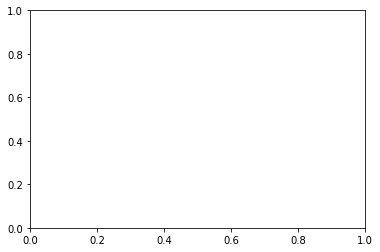

In [15]:
plt.plot(x_axis,p)